<a href="https://colab.research.google.com/github/aeapolimi/duckietown/blob/main/duckietown_stablebaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train duckietown with stable baseline

Environment setup 

In [8]:
import os 
if not os.path.isdir('gym-duckietown') or os.path.isdir('../gym-duckietown'):
  branch = "master" #@param ['master', 'daffy']
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if os.getcwd() != "/gym-duckietown":
  os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

Cloning into 'gym-duckietown'...
remote: Enumerating objects: 5528, done.
remote: Total 5528 (delta 0), reused 0 (delta 0), pack-reused 5528
Receiving objects: 100% (5528/5528), 79.01 MiB | 42.40 MiB/s, done.
Resolving deltas: 100% (3219/3219), done.
Obtaining file:///content/gym-duckietown/gym-duckietown
  Found existing installation: gym-duckietown 2019.0.0
    Can't uninstall 'gym-duckietown'. No files were found to uninstall.
  Running setup.py develop for gym-duckietown
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


Install stable baseline

In [9]:
# Stable baseline requires tensorflow 1.x
%tensorflow_version 1.x

In [10]:
!apt update && apt install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip3 install stable-baselines[mpi]
#This version with mpi is apparently broken, see:
#https://github.com/hill-a/stable-baselines/issues/464
!pip3 install stable-baselines --upgrade

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       

In [11]:
map_name = "Duckietown-straight_road-v0" #@param ['Duckietown-straight_road-v0','Duckietown-4way-v0','Duckietown-udem1-v0','Duckietown-small_loop-v0','Duckietown-small_loop_cw-v0','Duckietown-zigzag_dists-v0','Duckietown-loop_obstacles-v0','Duckietown-loop_pedestrians-v0']

Wrapper to highlight lines

In [12]:
import cv2
import gym
from gym.spaces import Box

def houghtransform(img):
        #cropped_img = img[image.shape[0]/2:image.shape[0]]
        #gray = cv2.cvtColor(cropped_img,cv2.COLOR_BGR2GRAY, 3)
        edges = cv2.Canny(cropped_img,50,150,apertureSize = 3)
        #minLineLength = 100
        #maxLineGap = 10
        #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
        #for x1,y1,x2,y2 in lines[0]:
        #    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        return edges.reshape(480,640,1)

class HoughObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(HoughObsWrapper, self).__init__(env)
        self.observation_space = Box(0, 255, (480, 640, 1), dtype=self.observation_space.dtype)
        self.accept_start_angle_deg = 4
        self.env = env

    def observation(self, obs):
        img = houghtransform(obs)
        return img

Wrapper result example:

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


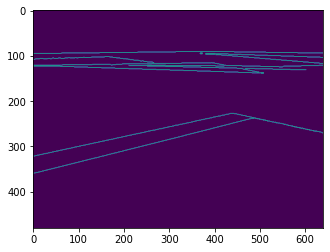

In [13]:
from gym_duckietown.envs import DuckietownEnv

display = Display(visible=0, size=(1400, 900))
display.start()
"""env = DuckietownEnv(
    map_name=map_name,
    draw_curve="store_true",
    draw_bbox="store_true",
    domain_rand="store_true",
    accept_start_angle_deg=4, 
)"""
env = gym.make(map_name, accept_start_angle_deg=4)
env = HoughObsWrapper(env)
plt.imshow(env.reset().reshape(480,640))

In [14]:
env.observation_space

Box(0, 255, (480, 640, 1), uint8)

In [ ]:
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines import A2C
from stable_baselines.common.policies import CnnLstmPolicy

model = A2C(CnnLstmPolicy, env, verbose=1)
model.learn(total_timesteps=20000)
model.save("a2c"+map_name)

ipythondisplay.clear_output(wait=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Wrapping the env in a DummyVecEnv.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




---------------------------------
| explained_variance | 0.000285 |
| fps                | 0        |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 9.7e+05  |
---------------------------------
---------------------------------
| explained_variance | -0.00401 |
| fps                | 16       |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 44.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0319   |
| fps                | 19       |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 4.75     |
---------------------------------
---------------------------------
| explained_variance | -0.00376 |
| fps                | 19       |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| total_timest

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: HoughObsWrapper(gym.make(map_name, accept_start_angle_deg=4))])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [ ]:
record_video(model, video_length=500, prefix=map_name)

In [ ]:
show_videos('videos', prefix=map_name)

In [ ]:
#from stable_baselines import A2C
#model = A2C.load("a2c"+map_name)